# MetaChest

This notebook generates `metachest.csv`.



### Generating CSV

In [1]:
from os.path import join

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import EngFormatter

from common import read_toml


plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{nimbusserif}',
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Nimbus Roman No9 L'],
    'font.size': 12,
})

metachest_dir = read_toml('config.toml')['metachest_dir']

Check files are available:

In [2]:
ds_names = ('chestxray14', 'chexpert', 'mimic', 'padchest')
df = pd.concat(
    pd.read_csv(join(metachest_dir, f'{ds_name}.csv'))
    for ds_name in ds_names
)
PATHOLOGIES = sorted(list(df.columns[5:]))
df = df[list(df.columns[:5]) + PATHOLOGIES]
df.head(10)

,dataset,name,age,sex,view,atelectasis,cardiomegaly,consolidation,edema,effusion,emphysema,fibrosis,hernia,infiltration,lung_opacity,mass,nodule,pleural_thickening,pneumonia,pneumothorax
0,chestxray14,00000001_000,57,m,pa,0,1,0,0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0,0
1,chestxray14,00000001_001,58,m,pa,0,1,0,0,0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0,0
2,chestxray14,00000001_002,58,m,pa,0,1,0,0,1,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0,0
3,chestxray14,00000003_001,74,f,pa,0,0,0,0,0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0,0
4,chestxray14,00000003_002,75,f,pa,0,0,0,0,0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0,0
5,chestxray14,00000003_003,76,f,pa,0,0,0,0,0,0.0,0.0,1.0,1.0,NaN,0.0,0.0,0.0,0,0
6,chestxray14,00000003_004,77,f,pa,0,0,0,0,0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0,0
7,chestxray14,00000003_005,78,f,pa,0,0,0,0,0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0,0
8,chestxray14,00000003_006,79,f,pa,0,0,0,0,0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0,0
9,chestxray14,00000003_007,80,f,pa,0,0,0,0,0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0,0


General stats:

In [3]:
labels_df = df[PATHOLOGIES].fillna(0).astype(int)
n_samples = labels_df.shape[0]
n_labels = labels_df.sum().sum()
label_cardinality = n_labels / n_samples
label_density = (labels_df.sum(axis=1) / labels_df.shape[1]).sum() / n_samples
print(
    f"Number of samples:\t {n_samples}",
    f"Number of labels:\t {n_labels}",
    f"Label cadinality:\t {label_cardinality}",
    f"Label density:\t\t {label_density}",
    sep='\n'
)

Number of samples:	 322475
Number of labels:	 596494
Label cadinality:	 1.8497371889293743
Label density:		 0.12331581259529159


Images per dataset:

In [4]:
df.groupby('dataset').count()['name']

dataset
chestxray14     50651
chexpert       130930
mimic          111869
padchest        29025
Name: name, dtype: int64

Compute total dataframe:

In [5]:
# group by dataset
ds_sum_df = df[['dataset'] + PATHOLOGIES].groupby('dataset').sum().astype(int)
# sorted pathologies and datasets sseries
ds_sum_sr = ds_sum_df.sum(axis=1).sort_values(ascending=False)
pt_sum_sr = ds_sum_df.sum(axis=0).sort_values(ascending=False)
# sort grouped df
ds_sum_df = ds_sum_df.reindex(list(ds_sum_sr.index))
ds_sum_df = ds_sum_df[list(pt_sum_sr.index)]

# total df
total_df = ds_sum_df.copy()
total_df.loc[:, 'total'] = total_df.sum(axis=1)
total_df.loc['total', :] = total_df.sum(axis=0)
total_df = total_df.astype(int)

Distribution plot:

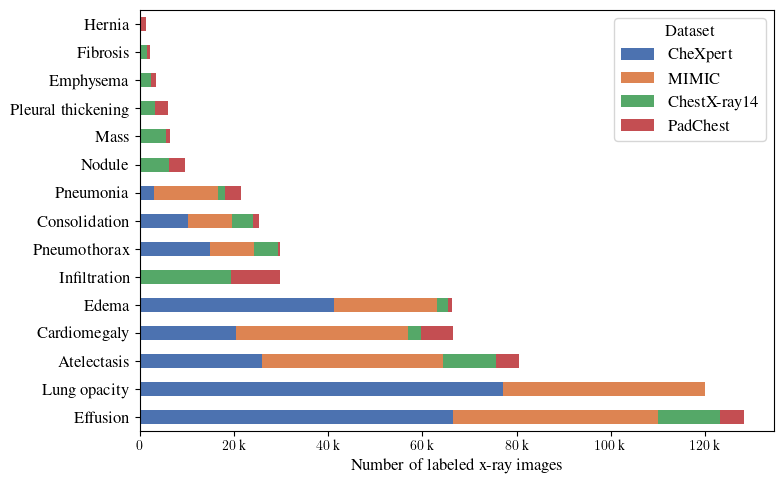

In [6]:
df_plot = ds_sum_df.T
df_plot = df_plot.rename(columns={
    'chestxray14': 'ChestX-ray14',
    'chexpert': 'CheXpert',
    'mimic': 'MIMIC',
    'padchest': 'PadChest'
})
df_plot = df_plot.rename(index={
    idx: idx.replace('_', ' ').capitalize()
    for idx in df_plot.index
})
ax = df_plot.plot.barh(stacked=True, figsize=(8, 5),
                       color=sns.color_palette('deep'))
ax.xaxis.set_major_formatter(EngFormatter())
ax.set_xlabel('Number of x-ray images')
ax.xaxis.set_tick_params(labelsize=10)
ax.legend(title='Dataset')
plt.tight_layout()
plt.savefig(join(metachest_dir, 'metachest.pdf'))
plt.savefig(join(metachest_dir, 'metachest.jpg'))

In [7]:
total_df.T

dataset,chexpert,mimic,chestxray14,padchest,total
effusion,66484,43544,13086,5075,128189
lung_opacity,77194,42779,0,0,119973
atelectasis,25980,38297,11335,4808,80420
cardiomegaly,20391,36512,2701,6782,66386
edema,41247,21894,2269,865,66275
infiltration,0,0,19362,10455,29817
pneumothorax,14977,9215,5220,306,29718
consolidation,10340,9183,4505,1197,25225
pneumonia,2986,13679,1381,3548,21594
nodule,0,0,6238,3429,9667


## Save

In [8]:
path = join(metachest_dir, 'metachest.csv')
df.to_csv(path, index=False)
path


'/data/datasets/metachest/metachest.csv'